# 210917 Gambit

In [1]:
from pathlib import Path

In [2]:
import numpy as np
import pandas as pd
import h5py as h5
from tqdm import tqdm
from scipy.stats import pearsonr, spearmanr

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

In [23]:
%matplotlib inline

## Setup

In [4]:
infiles = dict(
    genomes=Path('data-processed/210902-get-genomes/210902-mash-genomes-filtered.csv'),
    ani=Path('data-intermediate/210904-fastani'),
    gambit=Path('data-intermediate/210917-gambit'),
)

## Load data

### Genomes

In [5]:
genomes_df = pd.read_csv(infiles['genomes'], index_col='index')
ngenomes = genomes_df.shape[0]

### ANI

In [6]:
with h5.File('data-intermediate/210904-fastani/ani-pairwise.h5') as f:
    g1 = f['genome1'][:]
    g2 = f['genome2'][:]
    ani_pw = f['ani_mean'][:]

In [7]:
pw_index = pd.MultiIndex.from_arrays([g1, g2], names=['g1', 'g2'])
ani = pd.Series(ani_pw, index=pw_index)

### GAMBIT

In [8]:
params_df = pd.read_csv(infiles['gambit'] / 'params.csv')
# params_df.set_index(['k', 'prefix_len', 'prefix_version'], drop=True, inplace=True)

base_prefixes = params_df[params_df['prefix_len'] == 7].groupby('prefix_version')['prefix'].first()
base_prefixes.name = 'base_prefix'

params_df = params_df.join(base_prefixes.to_frame(), on='prefix_version')
params_df.set_index(['k', 'prefix_len', 'base_prefix'], inplace=True)

params_index = params_df.index

In [10]:
with h5.File(infiles['gambit'] / 'pairwise-dists.h5') as f:
    assert np.array_equal(f['genome1'][:], g1)
    assert np.array_equal(f['genome2'][:], g2)
    dists_mat = f['pw_dists'][:]
    kcounts_mat = f['kmer_counts'][:]

## Statistics

### K-mer counts

In [12]:
kcounts_wide = pd.DataFrame(kcounts_mat, index=params_index, columns=pd.RangeIndex(1, ngenomes+1, name='genome'))

In [30]:
kcounts_ts = kcounts_wide.stack()
kcounts_ts.name = 'count'

In [31]:
# Aggregate and add stats to params df
kcounts_gb = kcounts_ts.groupby(['k', 'prefix_len', 'base_prefix'])

params_df['count_mean'] = kcounts_gb.mean()
params_df['count_std'] = kcounts_gb.std()
params_df['count_cv'] = params_df['count_std'] / params_df['count_mean']

### Distances

In [17]:
dists_wide = pd.DataFrame(dists_mat, index=params_index, columns=pw_index)

In [19]:
params_df['ani_pearson'] = [-pearsonr(row, ani_pw)[0] for row in dists_mat]
params_df['ani_spearman'] = [-spearmanr(row, ani_pw)[0] for row in dists_mat]

## Plots

In [186]:
def param_heatmaps(value, gb, rows, cols, **kw):

    gb_index = params_index.names.index(gb)
    levels = params_index.levels[gb_index]
    nlevels = len(levels)

    fig, axs = plt.subplots(len(levels), 1, figsize=(16, 10), sharex=True, sharey=True)

    gb_obj = params_df.groupby(gb, sort=False)

    for ax, level in zip(axs, levels):
        df = gb_obj.get_group(level)
        df2 = pd.pivot(df.reset_index(), rows, cols, value)
        sns.heatmap(df2, ax=ax, **kw)
        ax.set_title(f'{gb} = {level}')
        
        if level != levels[-1]:
            ax.set_xlabel(None)
            
    fig.tight_layout()

### Correlation to ANI

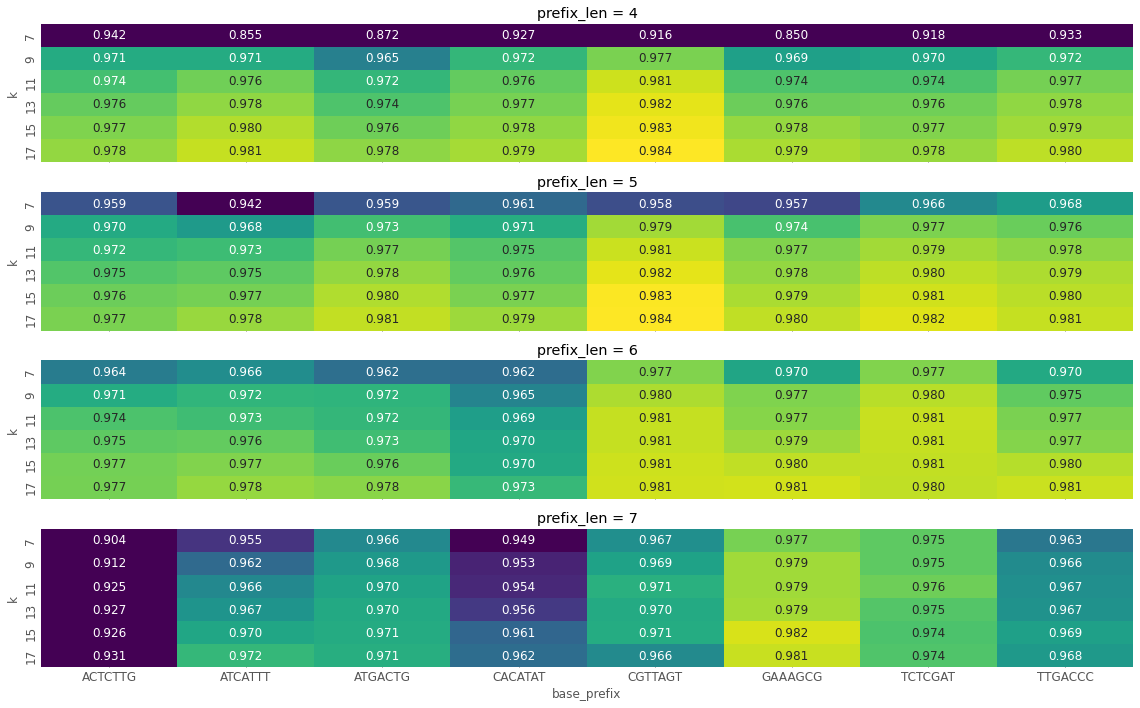

In [196]:
param_heatmaps(
    'ani_spearman',
    'prefix_len',
    'k',
    'base_prefix',
    annot=True,
    fmt='.3f',
#     vmin=params_df['ani_spearman'].min(),
    vmin=.95,
    vmax=params_df['ani_spearman'].max(),
    cbar=False,
    cmap='viridis',
)

## K-mer counts

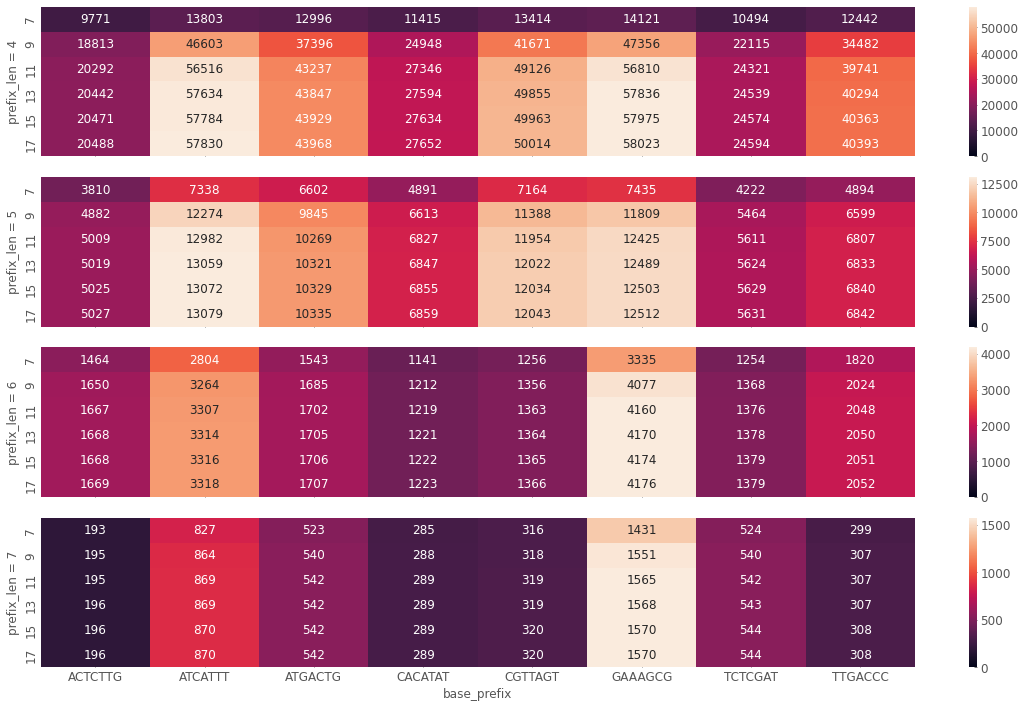

In [184]:
param_heatmaps('count_mean', 'prefix_len', 'k', 'base_prefix', annot=True, fmt='.0f', vmin=0)

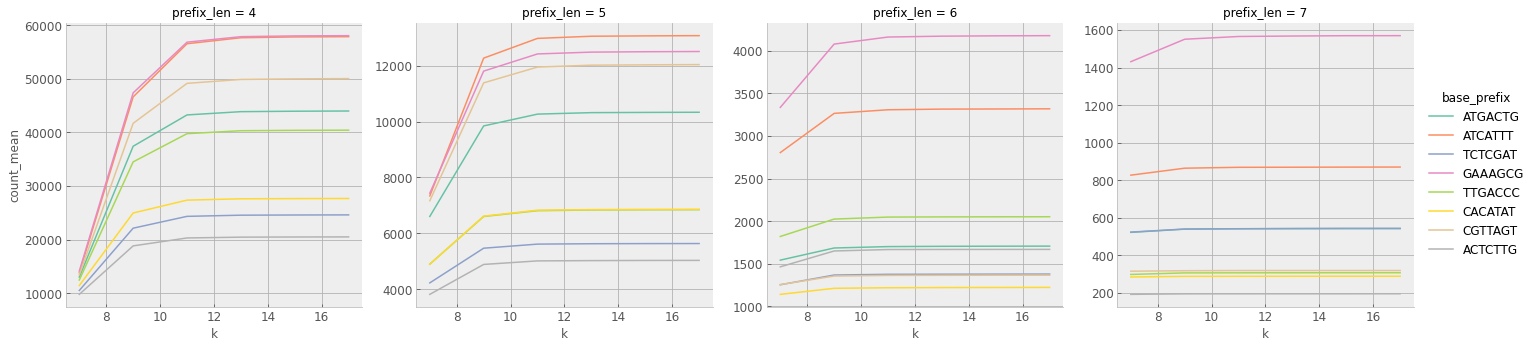

In [146]:
sns.relplot(
    kind='line',
    data=params_df.reset_index(),
    x='k',
    y='count_mean',
    hue='base_prefix',
    col='prefix_len',
    facet_kws=dict(sharey=False),
    markers=True,
    palette='Set2'
)

In [37]:
_.shape

(192, 192)

/home/jared/opt/anaconda3/envs/gambit/lib/python3.9/site-packages/seaborn/categorical.py:3808: UserWarning: Setting `sharey=False` with `color=None` may cause different levels of the `y` variable to share colors. This will change in a future version.
  warnings.warn(msg.format("sharey", "y"), UserWarning)


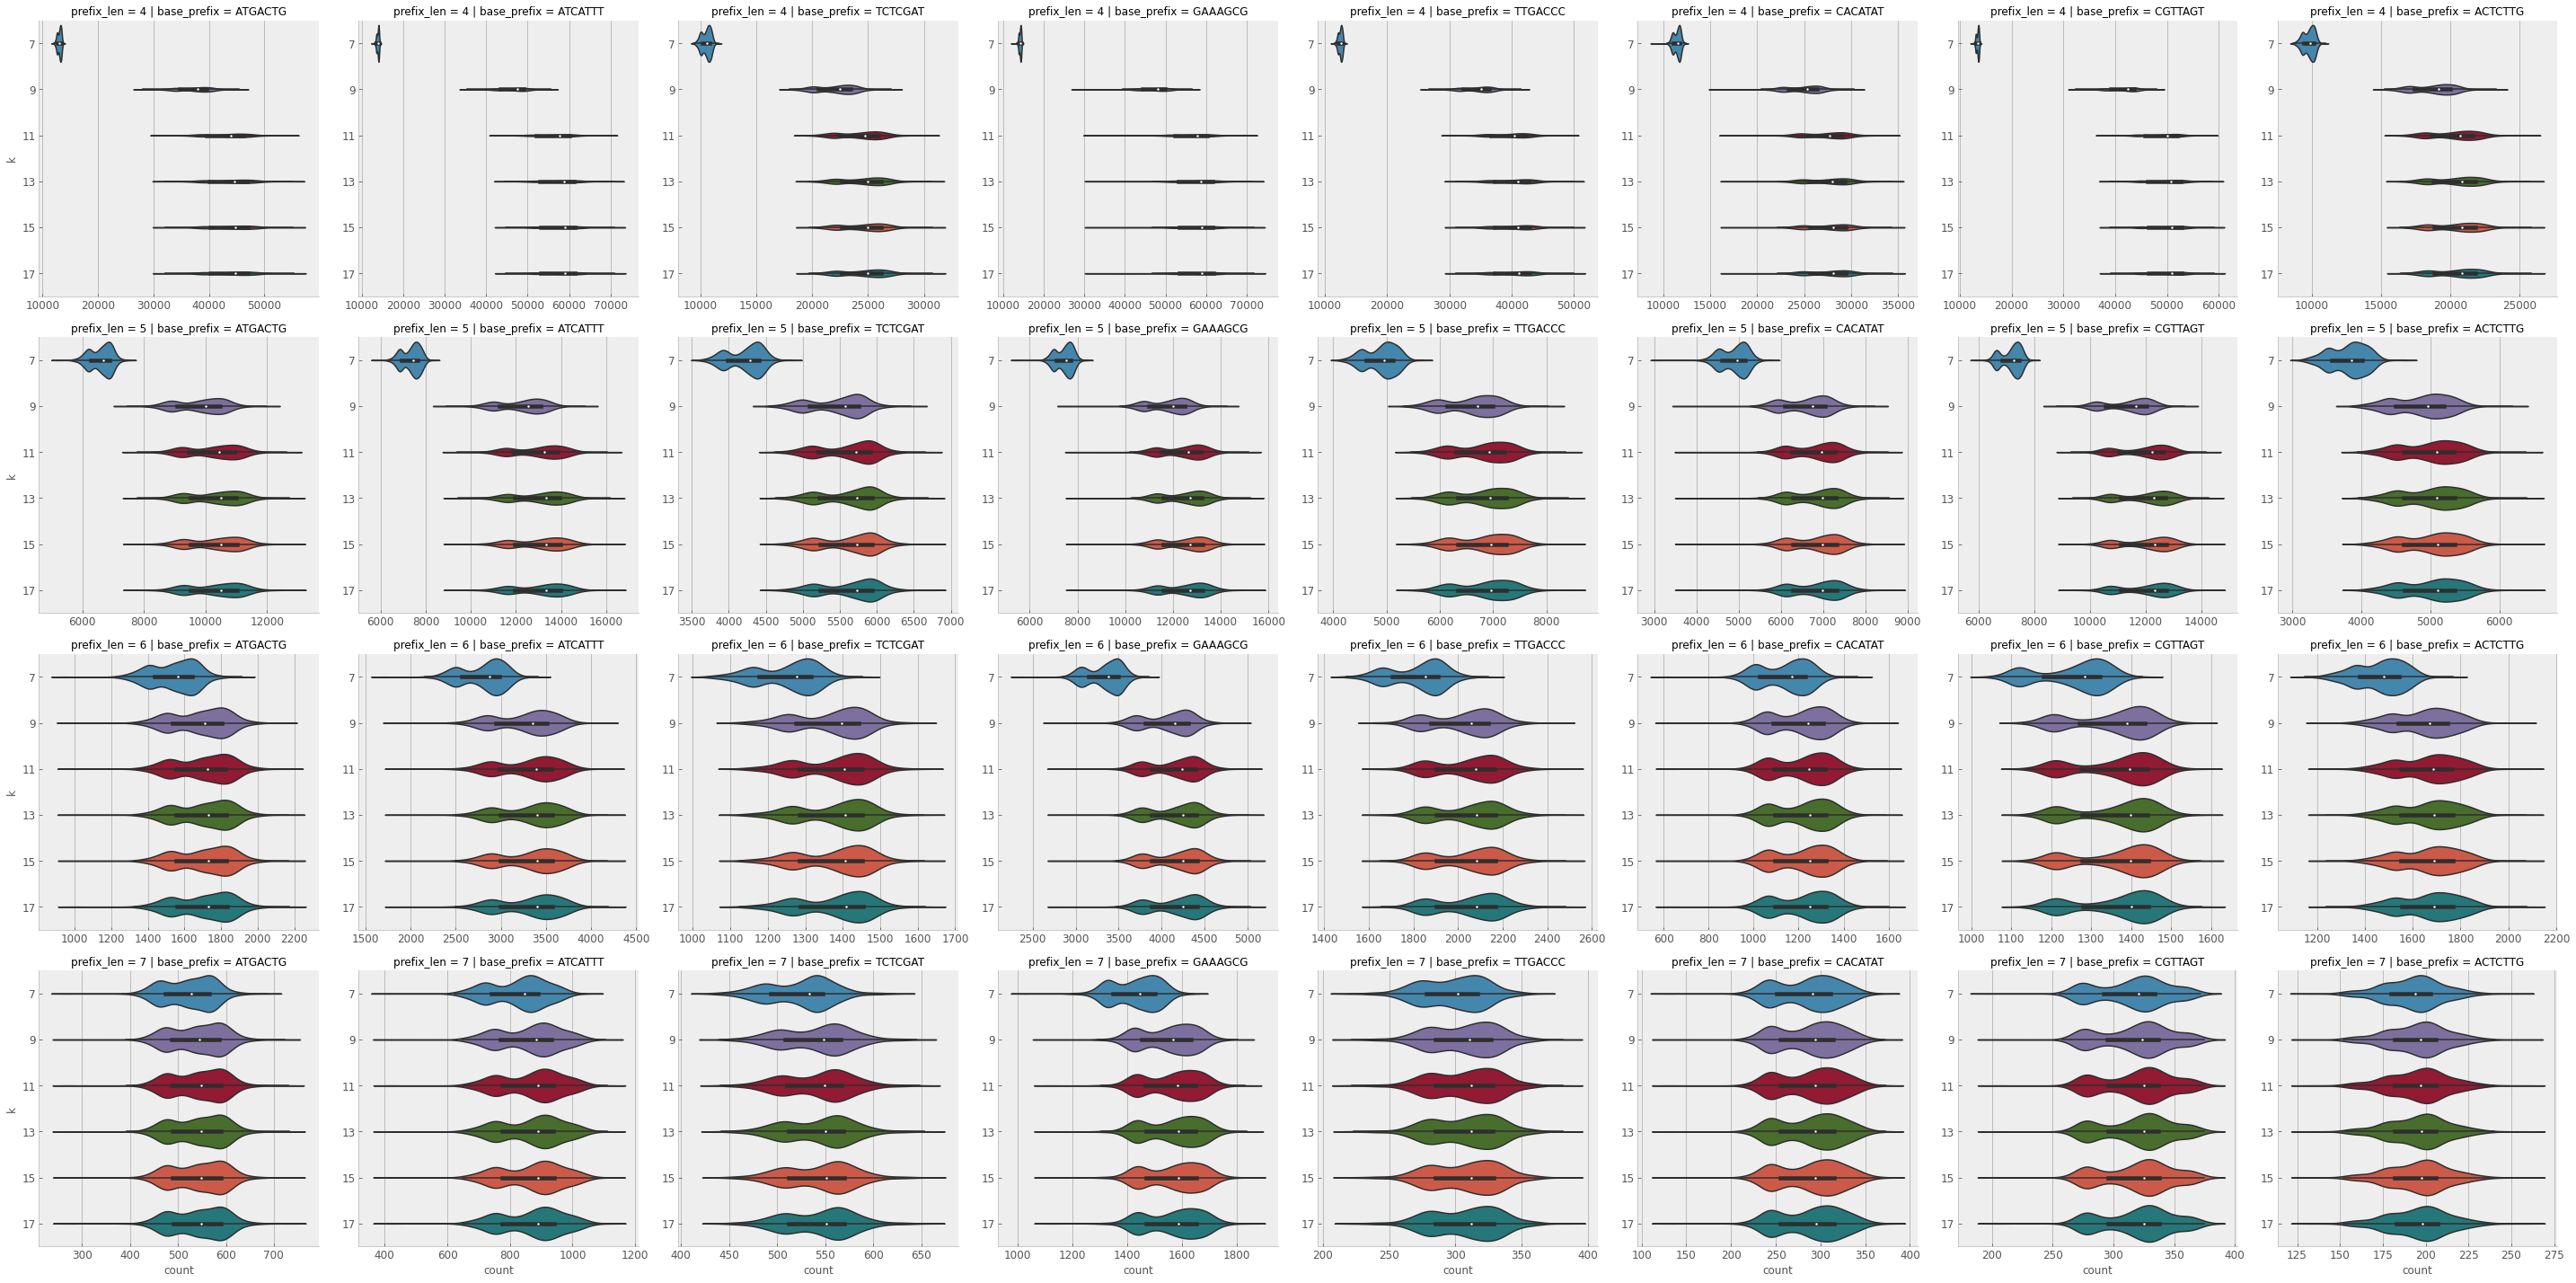

In [32]:
sns.catplot(
    data=kcounts_ts.reset_index(),
    kind='violin',
    orient='h',
    x='count',
    y='k',
    col='base_prefix',
    row='prefix_len',
    sharex=False,
    sharey=False,
)

In [ ]:
sns.relplot(
    data=counts_series.reset_index(),
    kind='line',
    y='count',
#     hue='prefix_version',
    hue='base_prefix',
    x='k',
    col='prefix_len',
#     sharex=False,
#     sharey=False,
)

## ?

In [ ]:
dists_ts = dists_wide.stack(['genome1', 'genome2']).to_frame('gambit')

In [ ]:
dists_ts = dists_ts.join(ani_series.to_frame('ani'), ['genome1', 'genome2'])

In [ ]:
dists_ts['ani_binned'] = np.round(dists_ts['ani'], 2)

In [ ]:
# _df = dists_ts.xs(slice(0, 2), level='prefix_version', drop_level=False)
_df = dists_ts
_df = _df.xs(11, level='k')
# _df = _df.xs(0, level='prefix_version', drop_level=False)

In [ ]:
sns.relplot(
    data=dists_ts.reset_index(),
#     data=_df.reset_index(),
    kind='line',
    x='ani_binned',
    y='gambit',
    row='prefix_len',
    col='k',
    hue='base_prefix',
    height=10,
)

In [ ]:
plt.figure(figsize=(16, 16))
_df = dists_ts.loc[11, 5, 0]
sns.histplot(data=_df.iloc[::1], x='ani', y='gambit')